In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from sklearn.metrics import f1_score, roc_auc_score 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')
from nltk.corpus import stopwords
np.random.seed(101)
%pylab inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Влад\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Populating the interactive namespace from numpy and matplotlib


In [2]:
train = pd.read_csv("./train.csv", header=None, encoding='latin-1', sep=',')
train.columns = ['sentiment', 'id', 'time', 'flag', 'username', 'text']
train = train.iloc[np.random.permutation(len(train))][:100000]
train.head()

,sentiment,id,time,flag,username,text
250977,0,1983354434,Sun May 31 12:59:58 PDT 2009,NO_QUERY,Yushimi,@Kardboard yea ugh. I don't wanna move either...
150064,0,1883616871,Fri May 22 08:50:14 PDT 2009,NO_QUERY,philwade,"Guess there's a first time for everything, my ..."
710275,0,2257860040,Sat Jun 20 15:00:38 PDT 2009,NO_QUERY,JBnVFCLover786,My cousin is going to America and it's NOT FAI...
367641,0,2049251254,Fri Jun 05 16:33:26 PDT 2009,NO_QUERY,ChelseyHart,@mitchelmusso Ahh this is my first comment to ...
575674,0,2211153017,Wed Jun 17 12:30:03 PDT 2009,NO_QUERY,GGirl33,taking care of my good friend jessica she is s...


In [3]:
train.sentiment.unique()

array([0, 4], dtype=int64)

In [4]:
test = pd.read_csv("./test.csv", encoding='latin-1', header=None)
test.columns = ['sentiment', 'id', 'time', 'flag', 'username', 'text']
test = test.drop(test[test.sentiment == 2].index)
test.head()

,sentiment,id,time,flag,username,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [5]:
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'[_"\-;%()|.,+&=*%]', '', tweet)
    tweet = re.sub(r'\.', ' . ', tweet)
    tweet = re.sub(r'\!', ' !', tweet)
    tweet = re.sub(r'\?', ' ?', tweet)
    tweet = re.sub(r'\,', ' ,', tweet)
    tweet = re.sub(r':', ' : ', tweet)
    tweet = re.sub(r'#', ' # ', tweet)
    #tweet = re.sub(r'@', ' @ ', tweet)
    tweet = re.sub(r'd .c .', 'd.c.', tweet)
    tweet = re.sub(r'u .s .', 'd.c.', tweet)
    tweet = re.sub(r' amp ', ' and ', tweet)
    tweet = re.sub(r'pm', ' pm ', tweet)
    tweet = re.sub(r'news', ' news ', tweet)
    tweet = re.sub(r' . . . ', ' ', tweet)
    tweet = re.sub(r' .  .  . ', ' ', tweet)
    tweet = re.sub(r' ! ! ', ' ! ', tweet)
    tweet = re.sub(r'&amp', 'and', tweet)
    return tweet

def preprocess(text, remove_stopwords=True):
    text = clean_tweet(text)
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        
    msg = " ".join(text)
    
    for t in text:
        if t.startswith('http'):
            msg = msg.replace(t, 'URL')
        if t.startswith('@'):
            msg = msg.replace(t, 'username')
    
    text = msg
    
    # Clean the text
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"    ", " ", text) # Remove any extra spaces
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    # Return a list of words
    return(text)

In [6]:
print('**BEFORE PREPROC:**', train['text'].values[0])
print('-'*4)
print('**AFTER PREPROC:** ', preprocess(train['text'].values[0]))

**BEFORE PREPROC:** @Kardboard yea  ugh. I don't wanna move either because all my textbooks and noted are all out on the table. Sigh.
----
**AFTER PREPROC:**  username yea ugh wanna move either textbooks noted table sigh


In [7]:
train = train[['text','sentiment']]
train['text'] = list(map(preprocess, train['text']))
train[:4]

,text,sentiment
250977,username yea ugh wanna move either textbooks n...,0
150064,guess there s first time everything cars broke...,0
710275,cousin going america fair know wayyy pppl does...,0
367641,username ahh first comment youu love xxxand pl...,0


In [8]:
test['text'] = list(map(preprocess, test['text']))
test[:4]

,sentiment,id,time,flag,username,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,username loooooooovvvvvveee kindle dx cool fan...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,reading kindle love lee childs good read
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,ok first assesment kindle fucking rocks
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,username love kindle i ve mine months never lo...


In [9]:
translate_labels = {0:0, 4:1} # 0:0 -- просто для наглядности:)
train.sentiment = [translate_labels[t] for t in train.sentiment]
test.sentiment = [translate_labels[t] for t in test.sentiment]

In [10]:
train.to_csv("preprocessed_train.csv", index=False)

In [11]:
transformer = TfidfVectorizer(min_df=40, max_features=6000)
X_train = transformer.fit_transform(train.text)

In [12]:
X_test = transformer.transform(test.text)

In [13]:
y_train = train.sentiment
y_test = test.sentiment

In [14]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
test_pred = lr.predict_proba(X_test)

In [16]:
test_pred[:5]

array([[0.04662513, 0.95337487],
       [0.05971427, 0.94028573],
       [0.18586407, 0.81413593],
       [0.72101228, 0.27898772],
       [0.51532979, 0.48467021]])

In [17]:
roc_auc_score(y_test, test_pred[:,1])

0.8664400571180232

_______________

In [18]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11169451029899066039
]


In [19]:
tokenizer = Tokenizer(char_level=False)

In [20]:
tokenizer.fit_on_texts(train.text)
vocab_size = len(tokenizer.word_index)

In [21]:
vocab_size

61896

In [22]:
train_seqs = tokenizer.texts_to_sequences(train.text)

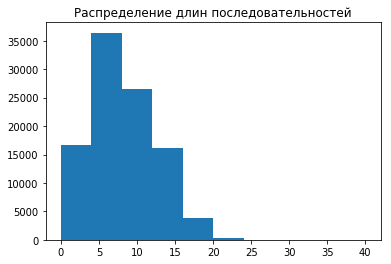

In [23]:
plt.hist([len(x) for x in train_seqs])
plt.title("Распределение длин последовательностей")
plt.show()

In [24]:
padded = pad_sequences(train_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)

In [25]:
padded.shape

(100000, 20)

In [26]:
filepath_glove = 'glove.twitter.27B.100d.txt'
glove_vocab = []
glove_embd=[]
embedding_dict = {}
 
file = open(filepath_glove,'r',encoding='UTF-8')
for line in file.readlines():
    row = line.strip().split(' ')
    vocab_word = row[0]
    glove_vocab.append(vocab_word)
    embed_vector = [float(i) for i in row[1:]] # convert to list of float
    embedding_dict[vocab_word]=embed_vector
file.close()

In [27]:
len(embedding_dict)

1193514

In [28]:
len(tokenizer.word_index)

61896

In [30]:

# prepare embedding matrix
num_words = vocab_size+1
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [31]:
embedding_matrix.shape

(61897, 100)

In [32]:
embedding_matrix[3]

array([ 8.5651e-02, -1.4665e-02, -2.0531e-01, -1.3928e-01, -4.5531e-01,
        6.6880e-01, -1.5448e-01,  3.2308e-01, -5.1561e-01,  9.6171e-02,
       -3.6832e-02,  2.7032e-01, -2.8622e+00,  4.1572e-01, -2.2041e-01,
       -8.2353e-01, -7.0891e-01, -3.1757e-01, -7.4595e-01,  1.1605e+00,
       -2.9937e-04, -1.3276e-02,  5.3844e-01,  3.2003e-01,  3.9048e-01,
       -2.2494e+00, -6.9214e-01, -3.2294e-01,  6.8427e-01,  5.9943e-01,
       -9.1371e-02, -5.6070e-01, -3.1685e-01, -1.1708e-01,  1.7076e+00,
       -6.3555e-01, -4.3287e-01, -2.2535e-01,  3.5899e-01,  2.3817e-01,
       -1.8517e+00,  3.0939e-01,  4.7932e-01, -8.7741e-01, -1.8584e-01,
       -5.0600e-01,  2.8379e-02, -7.2791e-01,  8.4749e-02, -7.0856e-01,
        3.5898e-01, -2.6869e-01,  1.2857e-01,  3.7286e-01,  3.6686e-01,
       -2.9323e-01,  3.7081e-01, -6.0298e-01,  2.4040e-01, -5.0550e-01,
       -2.8867e-01, -4.5598e-01,  7.7508e-02,  1.0154e-01,  2.9443e-01,
        4.2504e-01, -2.3515e-01,  4.4486e-01, -1.5291e-01, -1.04

In [45]:
tf.reset_default_graph()

__________

In [34]:
def batch_size_analisys(BATCH_SIZE):   
    emb_size = 100
    BATCH_SIZE = 100
    learning_rate = 0.001
    EPOCHS = 1
    y_train = np.array(train.sentiment)
    y_train = np.expand_dims(y_train, axis=1)
    dataset = tf.data.Dataset.from_tensor_slices((padded, y_train)).shuffle(BATCH_SIZE).repeat().batch(BATCH_SIZE)
    iterator = dataset.make_one_shot_iterator()
    get_next = iterator.get_next()
    print(get_next)
    inputs, labels = get_next
    with tf.variable_scope( "embedding_mtx", reuse=tf.AUTO_REUSE):
        embedding_mtx = tf.get_variable(name="embedding_mtx",
                                        shape=embedding_matrix.shape,
                                        initializer=tf.constant_initializer(embedding_matrix),
                                        trainable=False)
    inputs_embedded = tf.nn.embedding_lookup(params=embedding_mtx, ids=inputs)
    with tf.variable_scope( "states", reuse=tf.AUTO_REUSE):
        outputs, states = tf.nn.dynamic_rnn(cell=tf.nn.rnn_cell.LSTMCell(100), inputs=inputs_embedded, dtype=tf.float32)
    outputs = tf.layers.flatten(outputs)
    logits = tf.layers.dense(inputs=outputs, units=1)
    probs = tf.nn.sigmoid(logits)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.cast(labels, dtype=tf.float32),
        logits=logits,
        name='loss'
    )
    loss = tf.reduce_mean(loss)
    with tf.variable_scope( "train_op", reuse=tf.AUTO_REUSE):
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    losses = []
    num_epochs = 1
    num_iter_per_epoch = 3000

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for i in range(num_epochs):
        print('Epoch ',i)
        aver_loss = 0.
        for j in range(num_iter_per_epoch):
            loss_cur, _ = sess.run([loss, train_op])
            aver_loss += loss_cur
            if j % 300 == 0:
                print('Loss: ', aver_loss / 300.)
                aver_loss = 0.

            losses.append(loss_cur)

    test_seqs = tokenizer.texts_to_sequences(test.text)
    padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)
    test_pred = sess.run(probs, feed_dict={inputs: padded_test})
    print('Roc auc score: ', roc_auc_score(y_test, test_pred))

In [35]:
batch_size_analisys(200)

(<tf.Tensor 'IteratorGetNext:0' shape=(?, 20) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(?, 1) dtype=int64>)
Epoch  0
Loss:  0.002310922940572103
Loss:  0.5431242530544599
Loss:  0.5129935674866041
Loss:  0.5009064045548439
Loss:  0.4928040125966072
Loss:  0.48247292002042136
Loss:  0.48241712162892025
Loss:  0.47761032929023106
Loss:  0.46694743474324546
Loss:  0.46837378581364947
Roc auc score:  0.8859191655801825


In [36]:
batch_size_analisys(150)

(<tf.Tensor 'IteratorGetNext_1:0' shape=(?, 20) dtype=int32>, <tf.Tensor 'IteratorGetNext_1:1' shape=(?, 1) dtype=int64>)
Epoch  0
Loss:  0.002321139176686605
Loss:  0.5405810878674189
Loss:  0.5144708662231763
Loss:  0.5009268839160601
Loss:  0.4932903834184011
Loss:  0.48203336834907534
Loss:  0.4826710312565168
Loss:  0.47875728805859885
Loss:  0.46718964775403343
Loss:  0.46742642352978386
Roc auc score:  0.8797106847954306


In [37]:
batch_size_analisys(100)

(<tf.Tensor 'IteratorGetNext_2:0' shape=(?, 20) dtype=int32>, <tf.Tensor 'IteratorGetNext_2:1' shape=(?, 1) dtype=int64>)
Epoch  0
Loss:  0.0022823023796081543
Loss:  0.5455331586798032
Loss:  0.5139759284257889
Loss:  0.5010217472910881
Loss:  0.49125659515460335
Loss:  0.480667317310969
Loss:  0.48108950098355613
Loss:  0.47586575845877327
Loss:  0.46419204662243524
Loss:  0.46649639040231705
Roc auc score:  0.8796175575836591


In [38]:
batch_size_analisys(50)

(<tf.Tensor 'IteratorGetNext_3:0' shape=(?, 20) dtype=int32>, <tf.Tensor 'IteratorGetNext_3:1' shape=(?, 1) dtype=int64>)
Epoch  0
Loss:  0.0023321032524108885
Loss:  0.5448206051190694
Loss:  0.5145217421650886
Loss:  0.5016254949569702
Loss:  0.4936995334426562
Loss:  0.4832457122206688
Loss:  0.4827340105175972
Loss:  0.47842856516440707
Loss:  0.46603852609793345
Loss:  0.4672432368000348
Roc auc score:  0.8842739181722232


Я вывел значение roc auc при батчах размера 200, 150, 100 и 50. Можем заметить, что с уменьшением батча значение roc auc увеличивается.

_____________

In [39]:
def multiple_lstm_analisys(num_cells):   

    emb_size = 100
    BATCH_SIZE = 100
    learning_rate = 0.001
    EPOCHS = 1
    y_train = np.array(train.sentiment)
    y_train = np.expand_dims(y_train, axis=1)
    dataset = tf.data.Dataset.from_tensor_slices((padded, y_train)).shuffle(BATCH_SIZE).repeat().batch(BATCH_SIZE)
    iterator = dataset.make_one_shot_iterator()
    get_next = iterator.get_next()
    print(get_next)
    inputs, labels = get_next
    with tf.variable_scope( "embedding_mtx", reuse=tf.AUTO_REUSE):
        embedding_mtx = tf.get_variable(name="embedding_mtx",
                                        shape=embedding_matrix.shape,
                                        initializer=tf.constant_initializer(embedding_matrix),
                                        trainable=False)
    inputs_embedded = tf.nn.embedding_lookup(params=embedding_mtx, ids=inputs)
    
    stacked_rnn = []
    for iiLyr in range(num_cells):
        stacked_rnn.append(tf.nn.rnn_cell.LSTMCell(100, state_is_tuple=True))
    MultiLyr_cell = tf.nn.rnn_cell.MultiRNNCell(cells=stacked_rnn, state_is_tuple=True)
    
    with tf.variable_scope( "states", reuse=tf.AUTO_REUSE):
        outputs, states = tf.nn.dynamic_rnn(cell=MultiLyr_cell, inputs=inputs_embedded, dtype=tf.float32)
    outputs = tf.layers.flatten(outputs)
    logits = tf.layers.dense(inputs=outputs, units=1)
    probs = tf.nn.sigmoid(logits)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.cast(labels, dtype=tf.float32),
        logits=logits,
        name='loss'
    )
    loss = tf.reduce_mean(loss)
    with tf.variable_scope( "train_op", reuse=tf.AUTO_REUSE):
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    losses = []
    num_epochs = 1
    num_iter_per_epoch = 3000

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for i in range(num_epochs):
        print('Epoch ',i)
        aver_loss = 0.
        for j in range(num_iter_per_epoch):
            loss_cur, _ = sess.run([loss, train_op])
            aver_loss += loss_cur
            if j % 300 == 0:
                print('Loss: ', aver_loss / 200.)
                aver_loss = 0.

            losses.append(loss_cur)

    test_seqs = tokenizer.texts_to_sequences(test.text)
    padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)
    test_pred = sess.run(probs, feed_dict={inputs: padded_test})
    print('Roc auc score: ', roc_auc_score(y_test, test_pred))

In [40]:
multiple_lstm_analisys(2)

(<tf.Tensor 'IteratorGetNext_4:0' shape=(?, 20) dtype=int32>, <tf.Tensor 'IteratorGetNext_4:1' shape=(?, 1) dtype=int64>)
Epoch  0
Loss:  0.003492025136947632
Loss:  0.812435449808836
Loss:  0.7725379377603531
Loss:  0.7491498173773289
Loss:  0.738094082325697
Loss:  0.7245496365427971
Loss:  0.7241321703791619
Loss:  0.7171112543344498
Loss:  0.7013353668153286
Loss:  0.7042051681876182
Roc auc score:  0.8900788477059663


In [41]:
multiple_lstm_analisys(3)

(<tf.Tensor 'IteratorGetNext_5:0' shape=(?, 20) dtype=int32>, <tf.Tensor 'IteratorGetNext_5:1' shape=(?, 1) dtype=int64>)
Epoch  0
Loss:  0.0034739920496940613
Loss:  0.8136301659047603
Loss:  0.7748345257341862
Loss:  0.7533482572436333
Loss:  0.7410206462442875
Loss:  0.7283304740488529
Loss:  0.7249749009311199
Loss:  0.7181708399951457
Loss:  0.7026716002821922
Loss:  0.7047063168883324
Roc auc score:  0.8932141305022661


In [42]:
multiple_lstm_analisys(4)

(<tf.Tensor 'IteratorGetNext_6:0' shape=(?, 20) dtype=int32>, <tf.Tensor 'IteratorGetNext_6:1' shape=(?, 1) dtype=int64>)
Epoch  0
Loss:  0.0034765979647636415
Loss:  0.8220951153337955
Loss:  0.7753786681592465
Loss:  0.7560034257173538
Loss:  0.7427360098063945
Loss:  0.7267723239958286
Loss:  0.7272418949007988
Loss:  0.7206654554605484
Loss:  0.7042898027598858
Loss:  0.7044924329221248
Roc auc score:  0.8868193952939715


Я взял 1, 2, 3 и 4 слоя LSTM, можно заметить, что значение roc auc увеличивается с увеличением слоёв. Но, если мы возьмём 4 слоя, то значение станет ухудшаться. 

_________

In [43]:
def last_output_analisys():   
    emb_size = 100
    BATCH_SIZE = 100
    learning_rate = 0.001
    EPOCHS = 1
    y_train = np.array(train.sentiment)
    y_train = np.expand_dims(y_train, axis=1)
    dataset = tf.data.Dataset.from_tensor_slices((padded, y_train)).shuffle(BATCH_SIZE).repeat().batch(BATCH_SIZE)
    iterator = dataset.make_one_shot_iterator()
    get_next = iterator.get_next()
    print(get_next)
    inputs, labels = get_next
    with tf.variable_scope( "embedding_mtx", reuse=tf.AUTO_REUSE):
        embedding_mtx = tf.get_variable(name="embedding_mtx",
                                        shape=embedding_matrix.shape,
                                        initializer=tf.constant_initializer(embedding_matrix),
                                        trainable=False)
    inputs_embedded = tf.nn.embedding_lookup(params=embedding_mtx, ids=inputs)
    with tf.variable_scope( "states", reuse=tf.AUTO_REUSE):
        outputs, states = tf.nn.dynamic_rnn(cell=tf.nn.rnn_cell.LSTMCell(100), inputs=inputs_embedded, dtype=tf.float32)
    # states.h return the last output or the last hidden state
    outputs = tf.layers.flatten(states.h)
    logits = tf.layers.dense(inputs=outputs, units=1)
    probs = tf.nn.sigmoid(logits)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.cast(labels, dtype=tf.float32),
        logits=logits,
        name='loss'
    )
    loss = tf.reduce_mean(loss)
    with tf.variable_scope( "train_op", reuse=tf.AUTO_REUSE):
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    losses = []
    num_epochs = 1
    num_iter_per_epoch = 3000

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for i in range(num_epochs):
        print('Epoch ',i)
        aver_loss = 0.
        for j in range(num_iter_per_epoch):
            loss_cur, _ = sess.run([loss, train_op])
            aver_loss += loss_cur
            if j % 300 == 0:
                print('Loss: ', aver_loss / 300.)
                aver_loss = 0.

            losses.append(loss_cur)

    test_seqs = tokenizer.texts_to_sequences(test.text)
    padded_test = pad_sequences(test_seqs, maxlen=20, dtype='int32', padding='post', truncating='pre', value=0.0)
    test_pred = sess.run(probs, feed_dict={inputs: padded_test})
    print('Roc auc score: ', roc_auc_score(y_test, test_pred))

In [44]:
last_output_analisys()

(<tf.Tensor 'IteratorGetNext_7:0' shape=(?, 20) dtype=int32>, <tf.Tensor 'IteratorGetNext_7:1' shape=(?, 1) dtype=int64>)
Epoch  0
Loss:  0.0023188279072443646
Loss:  0.5459324980775515
Loss:  0.5195074926813443
Loss:  0.5043394421537717
Loss:  0.4949584251642227
Loss:  0.4865829625725746
Loss:  0.485296055773894
Loss:  0.48038550128539403
Loss:  0.4710685606797536
Loss:  0.4719792298475901
Roc auc score:  0.8877196250077606


Если взять только последние выходы на последнем шаге, то значение roc_auc увеличится. Было  0.8796175575836591, стало 0.8877196250077606.